In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [4]:
from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
obj = lambda: None
lmao = {"auth_host_name":'localhost', 'noauth_local_webserver':'store_true', 'auth_host_port':[8080, 8090], 'logging_level':'ERROR'}
for k, v in lmao.items():
    setattr(obj, k, v)
    
# authorization boilerplate code
SCOPES = 'https://www.googleapis.com/auth/drive.readonly'
store = file.Storage('token.json')
creds = store.get()
# The following will give you a link if token.json does not exist, the link allows the user to give this app permission
if not creds or creds.invalid:
    flow = client.flow_from_clientsecrets('client_id.json', SCOPES)
    creds = tools.run_flow(flow, store, obj)


Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=1057945119027-sijcalohjlua1klj8r04ochhvsm1qsgj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&access_type=offline&response_type=code

Enter verification code: 4/rwH-yuIi8EG0GysMWUOzLDqeIZcCnvwdWwSDfgBwWZsUrw4VnsGLoPk
Authentication successful.


In [8]:
import io
from googleapiclient.http import MediaIoBaseDownload
DRIVE = discovery.build('drive', 'v3', http=creds.authorize(Http()))
# if you get the shareable link, the link contains this id, replace the file_id below
file_id = '1TMGTDElEhkWLeKNAo2M-cU3Jo8NdteRu'
request = DRIVE.files().get_media(fileId=file_id)
# replace the filename and extension in the first field below
fh = io.FileIO('PT_LM.zip', mode='w')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))

Download 98%.
Download 100%.


In [9]:
!unzip PT_LM.zip

Archive:  PT_LM.zip
   creating: PT_LM/
   creating: PT_LM/models/
  inflating: PT_LM/models/pt_wt.pth  
  inflating: PT_LM/models/pt_wt_vocab.pkl  


In [10]:
#vocabulario
with open('PT_LM/models/pt_wt_vocab.pkl', 'rb') as f:
    itos = pickle.load(f)
vocab = Vocab(itos)

In [11]:
df_train = pd.read_csv('base_treino.csv',sep='|',encoding='utf-8')
df_train.head()

,Arquivo,indicacao,indication,ATC_1,ATC_2,ATC_3,ATC_4
0,bula2179,Este pomada é indicada para o alívio das manif...,This ointment is indicated for the relief of i...,D,D07,D07B,D07B1
1,bula96,Replenine-VF é indicado no tratamento de episó...,Replenine-VF is indicated for the treatment of...,B,B02,B02D,B02D2
2,bula1835,Hipertensão captopril é indicado para o tratam...,Hypertension Captopril is indicated for the tr...,C,C09,C09A,C09A0
3,bula1590,Transpulmin xarope é um expectorante destinado...,Transpulmin syrup is an expectorant intended f...,R,R05,R05C,R05C0
4,bula4244,Dutasterida trata e previne a progressão da hi...,Dutasterida treats and prevents the progressio...,G,G04,G04C,G04C3


In [12]:
df_valid= pd.read_csv('base_teste.csv',sep='|',encoding='utf-8')
df_valid.head()

,Arquivo,indicacao,indication,ATC_1,ATC_2,ATC_3,ATC_4
0,bula292,Cloridrato de ranitidina é indicado no tratame...,Hydrochloride Ranitidina is indicated for the ...,A,A02,A02B,A02B1
1,bula7742,"Hipercolesterolemia Primária ezetimiba, admini...","Primary Hypercholesterolaemia ezetimibe, admin...",C,C10,C10A,C10A9
2,bula2854,SURVANTAr beractanto é destinado à prevenção e...,SURVANTAr Beractant is intended for the preven...,R,R07,R07C,R07C0
3,bula2326,GASTROBENE está indicado para - distúrbios da ...,GASTROBENE is indicated for-disorders of gastr...,A,A03,A03F,A03F0
4,bula3390,Hidrofluxr é destinado ao tratamento da hipert...,HYDROFLUXR is intended for the treatment of ar...,C,C03,C03A,C03A3


In [16]:
data_lm = TextLMDataBunch.from_df('PT_LM',
                                  train_df=df_train,valid_df=df_valid,
                                  text_cols='indicacao',label_cols='ATC_1',
                                  vocab=vocab)

In [17]:
data_lm.show_batch()

idx,text
0,"xxunk , dermatite solar , dermatite de xxunk e prurido xxunk . xxbos xxmaj xxunk - xxup xxunk é indicado no tratamento de episódios xxunk e na manutenção de níveis xxunk de fator xxup ix , em pacientes diagnosticados com hemofilia xxup b. xxbos xxmaj hipertensão xxunk é indicado para o tratamento da hipertensão , por reduzir a pressão arterial nesses casos . xxmaj insuficiência xxmaj cardíaca xxunk é indicado"
1,"xxmaj diagnóstica da xxmaj xxunk xxmaj xxunk . xxbos xxmaj este medicamento é indicado como analgésico e xxunk . xxbos xxmaj este medicamento é destinado ao tratamento de xxunk xxunk intestinal sob todas as formas xxunk hepática xxunk . xxbos xxmaj xxunk creme é indicado para o tratamento de xxunk causadas por xxunk , leveduras , xxunk , etc . por ex . xxmaj xxunk xxunk , xxmaj xxunk xxunk"
2,"trato respiratório inferior . xxbos a vacina febre amarela atenuada é utilizada na prevenção da febre amarela , doença causada por um xxunk da família xxmaj xxunk , do gênero xxmaj xxunk . é recomendada para vacinação em áreas endêmicas ou xxunk ou para os viajantes que a elas se destinam . xxbos xxmaj xxunk está indicado para tratamento local de infecções xxunk xxunk causadas por xxmaj xxunk xxunk ."
3,xxunk e xxunk posterior difusa xxunk simpática conjuntivite alérgica xxunk xxunk xxunk óptica xxunk e xxunk . - xxmaj doenças xxmaj respiratórias xxmaj xxunk xxunk xxmaj síndrome de xxmaj xxunk não - xxunk por outros meios xxunk tuberculose pulmonar fulminante ou disseminada quando usado concomitantemente à quimioterapia xxunk apropriada xxunk por aspiração asma xxunk . - xxmaj distúrbios xxmaj xxunk xxmaj púrpura xxunk idiopática em adultos xxunk secundária em adultos
4,", acne xxunk , xxunk , xxunk , estomatite angular , dermatite por xxunk , xxunk xxunk xxunk e infecções xxunk por xxunk , como xxmaj xxunk xxunk , xxmaj xxunk xxunk e xxmaj xxunk xxunk . xxbos xxmaj xxunk creme deve ser usado para o tratamento dos seguintes tipos de xxunk xxmaj tinha dos pés plantar e xxunk xxmaj tinha xxunk xxmaj outras xxunk tinha do corpo e tinha"


In [23]:
learn_lm = language_model_learner(data_lm, AWD_LSTM,
                                  pretrained_fnames=['pt_wt', 'pt_wt_vocab'], 
                                  drop_mult=0.5,callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


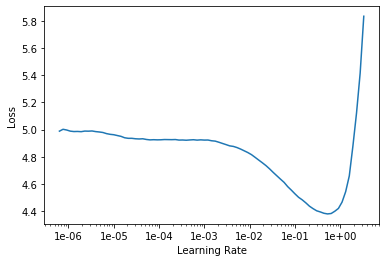

In [24]:
learn_lm.lr_find()
learn_lm.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,3.710422,3.141098,0.368920,00:21
1,3.003991,2.568490,0.433241,00:21
2,2.538592,2.222462,0.492348,00:21
3,2.248007,2.033310,0.530964,00:21
4,2.083187,1.927073,0.553875,00:21
5,1.992153,1.877649,0.566420,00:21
6,1.960120,1.875917,0.570125,00:21
7,1.917971,1.839330,0.577295,00:21
8,1.903718,1.828115,0.583848,00:21
9,1.849954,1.793160,0.595473,00:21


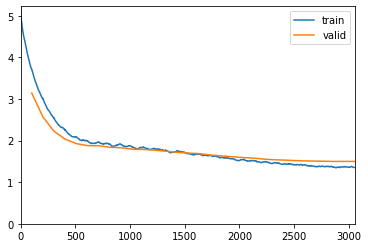

Better model found at epoch 0 with accuracy value: 0.3689196705818176.
Better model found at epoch 1 with accuracy value: 0.433241069316864.
Better model found at epoch 2 with accuracy value: 0.49234825372695923.
Better model found at epoch 3 with accuracy value: 0.5309643149375916.
Better model found at epoch 4 with accuracy value: 0.5538749694824219.
Better model found at epoch 5 with accuracy value: 0.5664196610450745.
Better model found at epoch 6 with accuracy value: 0.5701250433921814.
Better model found at epoch 7 with accuracy value: 0.5772947072982788.
Better model found at epoch 8 with accuracy value: 0.583848237991333.
Better model found at epoch 9 with accuracy value: 0.5954731702804565.
Better model found at epoch 10 with accuracy value: 0.5977678894996643.
Better model found at epoch 11 with accuracy value: 0.6027321815490723.
Better model found at epoch 12 with accuracy value: 0.6074195504188538.
Better model found at epoch 13 with accuracy value: 0.6161249876022339.
Bet

In [25]:
max_lr = 5e-2
learn_lm.fit_one_cycle(30, max_lr=max_lr, moms=(0.8,0.7), 
                       callbacks=[callbacks.SaveModelCallback(learn_lm, every='improvement', monitor='accuracy', name='learn_lm_PT_pt')])

In [26]:
#Carrego a melhor versão do language model
learn_lm.load('learn_lm_PT_pt')
learn_lm.save_encoder('enc_PT_pt')

In [33]:
data_clas = TextClasDataBunch.from_df('PT_LM',train_df=df_train,
                                      valid_df=df_valid,
                                      text_cols='indicacao',
                                      label_cols='ATC_1',
                                     vocab = data_lm.vocab)
data_clas.save('data_clas')

In [34]:
data_clas.show_batch()

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


text,target
"xxbos a xxunk é indicada para o alívio dos sintomas no caso de excesso de gases no aparelho xxunk constituindo motivo de dores ou cólicas xxunk , tais como - xxmaj xxunk - xxmaj xxunk - xxmaj xxunk - xxmaj xxunk pós - xxunk - xxmaj distensão xxunk - xxmaj xxunk xxmaj sabendo que os gases no trato digestivo atrapalham os exames abdominais de imagem e a xxunk facilita a",A
"xxbos xxup xxunk xxunk é destinado ao tratamento de condições nas quais os efeitos xxunk e imunossupressores dos corticosteroides são desejados , especialmente para tratamento intensivo durante períodos mais curtos . xxmaj indicações específicas xxup a. xxmaj por injeção intravenosa ou xxunk , quando não seja viável a terapia oral xxmaj insuficiência xxunk primária xxup xxunk xxunk possui atividade predominantemente xxunk , com baixa atividade xxunk . xxmaj por isso",H
xxbos xxunk 23 é indicada para vacinação contra doença xxunk causada pelos tipos de xxunk incluídos na vacina . a eficácia da vacina na prevenção de pneumonia xxunk e xxunk xxunk foi demonstrada em estudos clínicos controlados na xxmaj áfrica do xxmaj sul e na xxmaj frança e em estudos de caso - controle . xxunk 23 não previne contra doenças causadas por tipos xxunk de xxunk diferentes dos existentes,J
"xxbos xxmaj xxunk sulfato de xxunk é indicado para o tratamento de infecções causadas por cepas de bactérias sensíveis dos seguintes micro - organismos xxmaj xxunk xxunk , xxmaj proteus sp . xxunk - positivo e xxunk - negativo , xxmaj escherichia coli , xxmaj xxunk - xxmaj xxunk - xxmaj xxunk sp . , xxmaj xxunk sp . , xxmaj providencia sp . , xxmaj staphylococcus sp . xxunk",J
"xxbos xxmaj tratamento xxmaj neo xxmaj xxunk xxunk de xxunk é indicado no tratamento das seguintes infecções xxmaj febre das xxmaj montanhas xxmaj rochosas , febre tifoide e do grupo tifoide , febre q , varíola por xxunk e febre do carrapato causada por xxmaj xxunk xxmaj infecção respiratória causada por xxmaj xxunk xxunk xxmaj xxunk causada por xxmaj xxunk xxunk xxmaj xxunk xxunk causado por xxmaj xxunk xxunk xxmaj",J


In [35]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3, callback_fns=ShowGraph)
learn_clas.load_encoder('enc_PT_pt')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4827 items)
x: TextList
xxbos xxmaj este xxunk é indicada para o alívio das manifestações inflamatórias de xxunk sensíveis aos corticosteroides complicadas por infecção secundária causada por bactérias sensíveis à xxunk , ou quando houver suspeita de tais infecções . xxmaj estas xxunk incluem psoríase , dermatite alérgica de contato xxunk , dermatite xxunk , xxunk circunscrita xxunk simples crônico , xxunk plano , xxunk xxunk , xxunk xxunk , dermatite xxunk , dermatite xxunk , dermatite solar , dermatite de xxunk e prurido xxunk .,xxbos xxmaj xxunk - xxup xxunk é indicado no tratamento de episódios xxunk e na manutenção de níveis xxunk de fator xxup ix , em pacientes diagnosticados com hemofilia xxup b.,xxbos xxmaj hipertensão xxunk é indicado para o tratamento da hipertensão , por reduzir a pressão arterial nesses casos . xxmaj insuficiência xxmaj cardíaca xxunk é indicado no tratamento da insuficiência cardíaca xxunk em associação

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


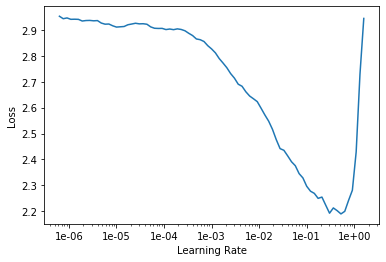

In [36]:
learn_clas.lr_find()
learn_clas.recorder.plot()

epoch,train_loss,valid_loss,accuracy,time
0,1.595749,0.990692,0.738194,00:07
1,1.161542,0.627521,0.846727,00:07
2,0.985381,0.541391,0.854184,00:09
3,0.856789,0.587723,0.845899,00:07
4,0.837383,0.502478,0.861640,00:08
5,0.766831,0.563993,0.840099,00:07
6,0.712704,0.482177,0.861640,00:07
7,0.749009,0.650887,0.819387,00:07
8,0.695525,0.564623,0.855012,00:07
9,0.765911,0.488989,0.873239,00:08


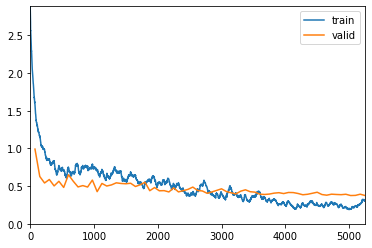

Better model found at epoch 0 with accuracy value: 0.7381938695907593.
Better model found at epoch 1 with accuracy value: 0.8467274308204651.
Better model found at epoch 2 with accuracy value: 0.8541839122772217.
Better model found at epoch 4 with accuracy value: 0.861640453338623.
Better model found at epoch 9 with accuracy value: 0.8732394576072693.
Better model found at epoch 13 with accuracy value: 0.8856669664382935.
Better model found at epoch 26 with accuracy value: 0.8914664387702942.
Better model found at epoch 27 with accuracy value: 0.893951952457428.
Better model found at epoch 30 with accuracy value: 0.8997514247894287.
Better model found at epoch 36 with accuracy value: 0.9088649749755859.
Better model found at epoch 45 with accuracy value: 0.911350429058075.
Better model found at epoch 47 with accuracy value: 0.9138359427452087.
Better model found at epoch 48 with accuracy value: 0.9171499609947205.
Better model found at epoch 56 with accuracy value: 0.9188069701194763.


In [37]:
max_lr = 3e-2
learn_clas.fit_one_cycle(70, max_lr=max_lr , moms=(0.8,0.7),
                         callbacks=[callbacks.SaveModelCallback(learn_clas, every='improvement', monitor='accuracy', name='learn_clas')])

In [38]:
learn_clas.load('learn_clas')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (4827 items)
x: TextList
xxbos xxmaj este xxunk é indicada para o alívio das manifestações inflamatórias de xxunk sensíveis aos corticosteroides complicadas por infecção secundária causada por bactérias sensíveis à xxunk , ou quando houver suspeita de tais infecções . xxmaj estas xxunk incluem psoríase , dermatite alérgica de contato xxunk , dermatite xxunk , xxunk circunscrita xxunk simples crônico , xxunk plano , xxunk xxunk , xxunk xxunk , dermatite xxunk , dermatite xxunk , dermatite solar , dermatite de xxunk e prurido xxunk .,xxbos xxmaj xxunk - xxup xxunk é indicado no tratamento de episódios xxunk e na manutenção de níveis xxunk de fator xxup ix , em pacientes diagnosticados com hemofilia xxup b.,xxbos xxmaj hipertensão xxunk é indicado para o tratamento da hipertensão , por reduzir a pressão arterial nesses casos . xxmaj insuficiência xxmaj cardíaca xxunk é indicado no tratamento da insuficiência cardíaca xxunk em associação

In [39]:
interp = ClassificationInterpretation.from_learner(learn_clas)

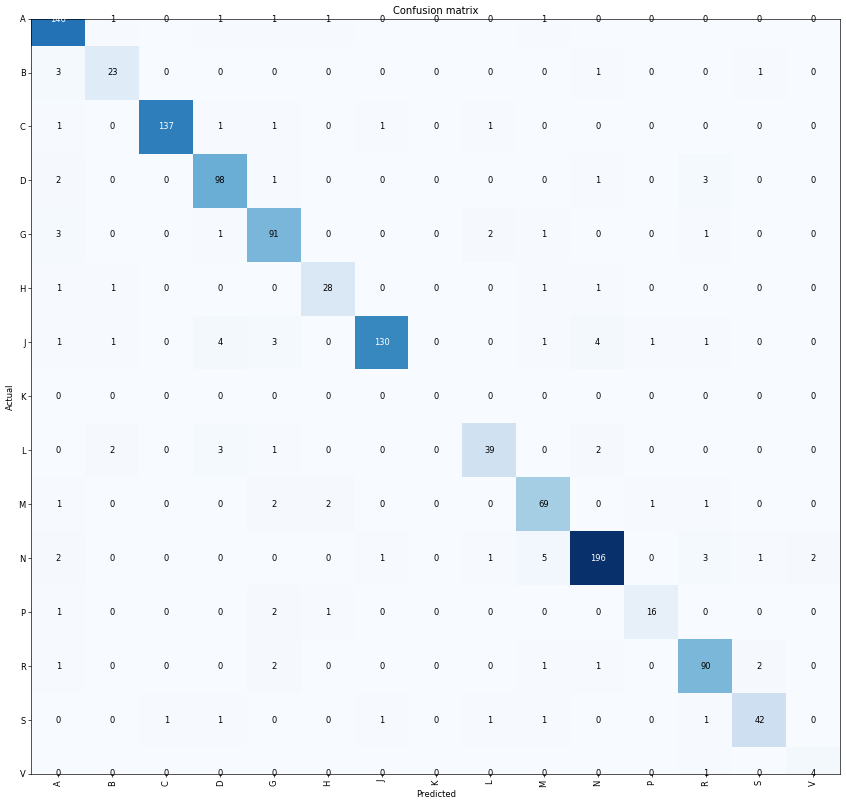

In [40]:
interp.plot_confusion_matrix(figsize=(14,14), dpi=60)